# WET-006: pairing vs stacking for wavefront estimation

In this document we compare two approaches for wavefront estimation for the Rubin Observatory Active Optics System (AOS).  The first (default) approach, dubbed "pairing", is using individual donut pairs and averaging their final Zk estimate. The second approach ("stacking") involves aggregating individual donut stamps prior to wavefront fitting and using their combined information (a stacked stamp) to obtain a single set of Zernike polynomials per stacked donut image. For an overview of pairing vs stacking, also see https://sitcomtn-085.lsst.io/.

   
Last verified to run: 09/19/2024

Versions:

* **lsst_distrib** w_2024_32 (ext, cvmfs)

* **ts_wep** v11.4.0


## Setup on USDF

We import all required packages:



In [ ]:
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
from astropy.io import fits
from lsst.daf import butler as dafButler
import numpy as np
from lsst.ts.wep.utils import (
    WfAlgorithmName,
    getTaskInstrument,
    getCameraFromButlerName
)
from lsst.ts.wep.image import Image
import stacking
import os

## Data processing 

The data was processed by running  first ISR (`lsstPipelineISRdoVar.yaml` ):

    description: run ISR on raws
    instrument: lsst.obs.lsst.LsstCam
    tasks:
      isr:
        class: lsst.ip.isr.isrTask.IsrTask
        config:
          connections.outputExposure: 'postISRCCD'
          doBias: False
          doVariance: True
          doLinearize: False
          doCrosstalk: False
          doDefect: False
          doNanMasking: False
          doInterpolate: False
          doBrighterFatter: False
          doDark: False
          doFlat: False
          doApplyGains: True
          doFringe: False
          doOverscan: True
          python: OverscanCorrectionTask.ConfigClass.fitType = 'MEDIAN'

Then WEP donut direct detection and cutout (`lsstPipelineDirectCutoutOnly.yaml`):

    description: detect and cutout donuts 
    instrument: lsst.obs.lsst.LsstCam
    tasks:
      generateDonutDirectDetectTask:
        class: lsst.ts.wep.task.generateDonutDirectDetectTask.GenerateDonutDirectDetectTask
        config:
          donutSelector.useCustomMagLimit: True
      cutOutDonutsCwfsTask:
        class: lsst.ts.wep.task.cutOutDonutsCwfsTask.CutOutDonutsCwfsTask
    

Then separately using the donut postage stamps to obtain  `Danish`-based (`lsstPipelineCalcDanishOnly.yaml`):


    description: calculate Zernikes with Danish
    instrument: lsst.obs.lsst.LsstCam
    tasks:
      calcZernikesTask:
        class: lsst.ts.wep.task.calcZernikesTask.CalcZernikesTask
        config:
           python: |
              from lsst.ts.wep.task import EstimateZernikesDanishTask
              config.estimateZernikes.retarget(EstimateZernikesDanishTask)


or `TIE`-based wavefront estimation (`lsstPipelineCalcTieOnly.yaml`):


    description: calculate Zernikes with TIE
    instrument: lsst.obs.lsst.LsstCam
    tasks:
      calcZernikesTask:
        class: lsst.ts.wep.task.calcZernikesTask.CalcZernikesTask
        config:
           python: |
              from lsst.ts.wep.task import EstimateZernikesTieTask
              config.estimateZernikes.retarget(EstimateZernikesTieTask)

The succession of these was run with in a new repo where we first register the instrument, write calibrations, and ingest the raws:

In [8]:
pathCwd = "/sdf/group/rubin/shared/scichris/DM-42718_WET-006"
butlerRootPath = os.path.join(pathCwd, "newRepo")
outputImgDir = (
    "/sdf/data/rubin/user/gmegias/projects/commissioning_sims/WET-001_lsstcam/state_*"
)

cmd1 = f"butler create {butlerRootPath}"

butlerInstName = "Cam"
cmd2 = f"butler register-instrument {butlerRootPath} lsst.obs.lsst.Lsst{butlerInstName}"
cmd3 = f"butler write-curated-calibrations {butlerRootPath} lsst.obs.lsst.Lsst{butlerInstName}"
cmd4 = f"butler ingest-raws {butlerRootPath} {outputImgDir}/amp*"

print(cmd1, "\n")
print(cmd2, "\n")
print(cmd3, "\n")
print(cmd4, "\n")

butler create /sdf/group/rubin/shared/scichris/DM-42718_WET-006/newRepo 

butler register-instrument /sdf/group/rubin/shared/scichris/DM-42718_WET-006/newRepo lsst.obs.lsst.LsstCam 

butler write-curated-calibrations /sdf/group/rubin/shared/scichris/DM-42718_WET-006/newRepo lsst.obs.lsst.LsstCam 

butler ingest-raws /sdf/group/rubin/shared/scichris/DM-42718_WET-006/newRepo /sdf/data/rubin/user/gmegias/projects/commissioning_sims/WET-001_lsstcam/state_*/amp* 



Then we run ISR, and each WEP pipetasks separately so that they are in collections that can be reused. Each was run with bps on USDF, with the following prerequisites:


    source /sdf/group/rubin/sw/w_latest/loadLSST.bash   && setup lsst_distrib

source `setup_aos.sh`, which contains:

    #!/usr/bin/env bash
    export PATH_TO_TS_WEP=/sdf/data/rubin/user/scichris/WORK/aos_packages/ts_wep/
    export PATH_TO_TS_OFC=/sdf/data/rubin/user/scichris/WORK/aos_packages/ts_ofc/
    export PATH_TO_TS_IMSIM=/sdf/data/rubin/user/scichris/WORK/aos_packages/ts_imsim/
    
    eups declare -r $PATH_TO_TS_WEP -t $USER --nolocks
    eups declare -r $PATH_TO_TS_OFC -t $USER --nolocks
    eups declare -r $PATH_TO_TS_IMSIM -t $USER --nolocks
    
    setup ts_ofc -t $USER  -t current
    setup ts_wep -t $USER  -t current
    setup ts_imsim -t $USER -t current 
    
    export LSST_ALLOW_IMPLICIT_THREADS=True

Then 


    cd /sdf/group/rubin/shared/scichris/DM-42718_WET-006/
    allocateNodes.py -v -n 10 -c 64 -m 60:00:00 -q roma,milano -g 1800 s3df --account rubin:commissioning




In [10]:
isrCollection = "run_isr_all"
cutoutsCollection = "all_states_direct_stamps"
tieCollection = "all_states_direct_TIE"
danishCollection = "all_states_direct_Danish"

isrYaml = "lsstPipelineISRdoVar.yaml"
cutoutYaml = "lsstPipelineDirectCutoutOnly.yaml"
danishYaml = "lsstPipelineCalcDanishOnly.yaml"
tieYaml = "lsstPipelineCalcTieOnly.yaml"

isrYamlPath = os.path.join(pathCwd, isrYaml)
cutoutYamlPath = os.path.join(pathCwd, cutoutYaml)
danishYamlPath = os.path.join(pathCwd, danishYaml)
tieYamlPath = os.path.join(pathCwd, tieYaml)

nCores = 50

cmdIsr = f"bps submit site_bps.yaml  -b  {butlerRootPath} -i  LSSTCam/raw/all,LSSTCam/calib/unbounded \
-o {isrCollection} -p {isrYamlPath} -j {nCores}"


cmdCutout = f"bps submit site_bps.yaml  -b  {butlerRootPath} -i {isrCollection},LSSTCam/calib/unbounded \
-o {cutoutsCollection}  -p {cutoutYamlPath} -j {nCores}"

cmdDanish = f"bps submit site_bps.yaml  -b  {butlerRootPath} -i {cutoutsCollection} \
-o {danishCollection}  -p {danishYamlPath} -j {nCores}"

cmdTie = f"bps submit site_bps.yaml  -b  {butlerRootPath} -i {cutoutsCollection} \
-o {tieCollection}  -p {tieYamlPath} -j {nCores}"

print(cmdIsr, "\n")
print(cmdCutout, "\n")
print(cmdDanish, "\n")
print(cmdTie, "\n")


bps submit site_bps.yaml  -b  /sdf/group/rubin/shared/scichris/DM-42718_WET-006/newRepo -i  LSSTCam/raw/all,LSSTCam/calib/unbounded -o run_isr_all -p /sdf/group/rubin/shared/scichris/DM-42718_WET-006/lsstPipelineISRdoVar.yaml -j 50 

bps submit site_bps.yaml  -b  /sdf/group/rubin/shared/scichris/DM-42718_WET-006/newRepo -i run_isr_all,LSSTCam/calib/unbounded -o all_states_direct_stamps  -p /sdf/group/rubin/shared/scichris/DM-42718_WET-006/lsstPipelineDirectCutoutOnly.yaml -j 50 

bps submit site_bps.yaml  -b  /sdf/group/rubin/shared/scichris/DM-42718_WET-006/newRepo -i all_states_direct_stamps -o all_states_direct_Danish  -p /sdf/group/rubin/shared/scichris/DM-42718_WET-006/lsstPipelineCalcDanishOnly.yaml -j 50 

bps submit site_bps.yaml  -b  /sdf/group/rubin/shared/scichris/DM-42718_WET-006/newRepo -i all_states_direct_stamps -o all_states_direct_TIE  -p /sdf/group/rubin/shared/scichris/DM-42718_WET-006/lsstPipelineCalcTieOnly.yaml -j 50 



## Illustration of WET-001 states 

Note that each state contains randomly drawn modes:

In [18]:
butler = dafButler.Butler(butlerRootPath)
registry = butler.registry
datasetRefs = registry.queryDatasets('postISRCCD',collections=['run_isr_all'],
                                     where=f"instrument='LSSTCam' ").expanded()
print(len(list(datasetRefs)))
dataIds = []
for ref in datasetRefs:
    dataIds.append(ref.dataId)
    

800


In [20]:
# read in the images:
exposures = {}
for s in range(4):
    exposures[s] = butler.get('postISRCCD', 
                      dataId=dataIds[s], 
                      collections=['run_isr_all']
                             )

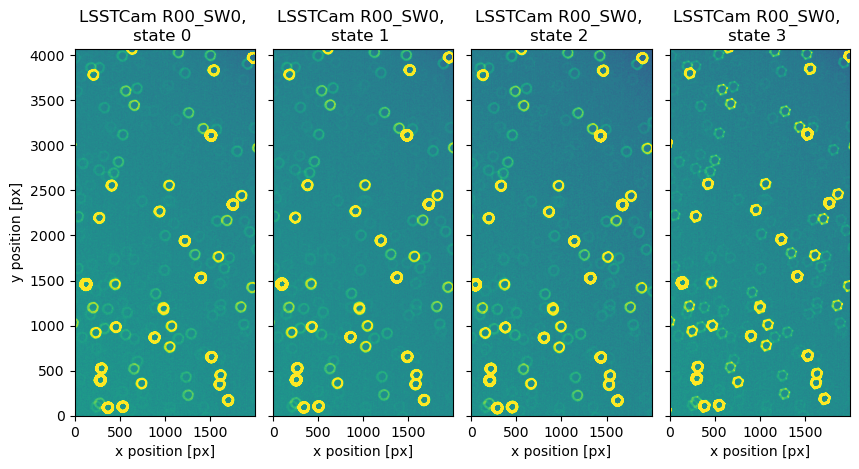

In [21]:
# plot the example exposures
fig, ax = plt.subplots(1, 4, figsize=(10, 5))

zscale = ZScaleInterval()
i = 0
for state, exposure in exposures.items():
    d = exposure.image.array
    vmin, vmax = zscale.get_limits(d)
    mappable = ax[i].imshow(d.T, vmin=vmin, vmax=vmax, origin="lower")

    ax[i].set_title(
        f"{exposure.visitInfo.instrumentLabel} {exposure.detector.getName()}, \nstate {state} ",
    )
    ax[i].set_xlabel("x position [px]")
    i += 1
ax[0].set_ylabel("y position [px]")

for i in range(1, 4):
    ax[i].set_yticklabels([])
fig.subplots_adjust(wspace=0.1)

# Perform stacking 

Stacking can be performed with the code in the attached `stacking.py` file. We combine information contained in each stamp on a pixel by pixel basis.  If using a donut mask, then only the values inside the mask are combined for the donut component. In that case, the image values outside the mask can be also averaged (left panel below) or set to 0 (middle panel). If not using the donut mask, the mean of the entire stack is calculated (right panel). Each donut contains field coordinates used by WEP to find a mask for wavefront fitting. In stacking, the x,y field coordinates of the stacked donut are a mean of field coordinates of component donuts. We find that for Danish there is a minimum background threshold, which means that it cannot be run entirely without background. TIE works in all conditions, including a donut stack with no background.

/tmp/ipykernel_44053/2159255477.py:81: RuntimeWarning: Mean of empty slice
  donutStackedArray = np.nanmean(image_stack, axis=0)


Text(0.5, 0.98, 'state 2, detector R44')

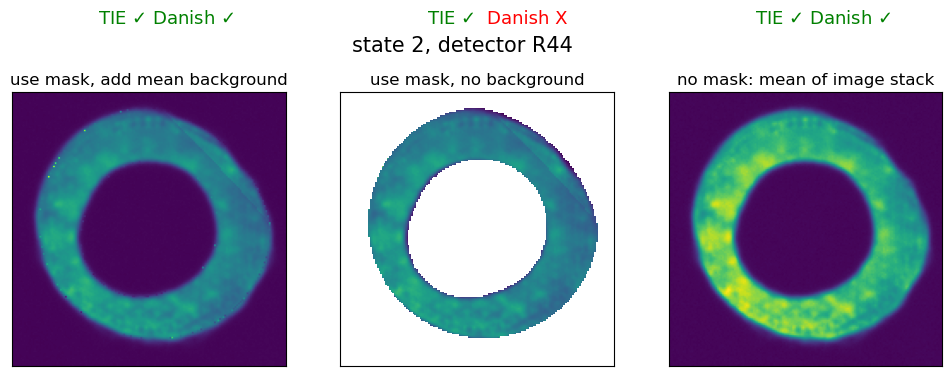

In [25]:
butlerRootPath = "/sdf/group/rubin/shared/scichris/DM-42718_WET-006/newRepo"
output_collection = "all_states_direct_stamps"

butler = dafButler.Butler(butlerRootPath)

dataId = {"instrument": "LSSTCam", "detector": 203, "visit": 5024072302002}
stampsIntra = butler.get(
    "donutStampsIntra", dataId=dataId, collections=[output_collection]
)
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
ax = np.ravel(axs)

i = 0
use_mask = True
add_bkgnd = True
# set the file name title
string = "no"
if use_mask:
    string = "use"

bkgnd = "no"
if add_bkgnd:
    bkgnd = "with"
stackedIntra = stack_donut_wep_im_refactor(
    stampsIntra,
    N=len(stampsIntra),
    pixel_stack="nanmean",
    use_mask=use_mask,
    after_avg_fill_with_bkgnd=add_bkgnd,
)
ax[i].imshow(
    stackedIntra["wep_im"].image,
    origin="lower",
)
ax[i].set_title(f"{string} mask, add mean background")

i = 1
use_mask = True
add_bkgnd = False
# set the file name title
string = "no"
if use_mask:
    string = "use"

bkgnd = "no"
if add_bkgnd:
    bkgnd = "with"
stackedIntra = stack_donut_wep_im_refactor(
    stampsIntra,
    N=len(stampsIntra),
    pixel_stack="nanmean",
    use_mask=use_mask,
    after_avg_fill_with_bkgnd=add_bkgnd,
)
ax[i].imshow(
    stackedIntra["wep_im"].image,
    origin="lower",
)
ax[i].set_title(f"{string} mask, {bkgnd} background")

i = 2
use_mask = False
# set the file name title
string = "no"
if use_mask:
    string = "use"

bkgnd = "no"
if add_bkgnd:
    bkgnd = "with"
stackedIntra = stack_donut_wep_im_refactor(
    stampsIntra,
    N=len(stampsIntra),
    pixel_stack="nanmean",
    use_mask=use_mask,
    after_avg_fill_with_bkgnd=add_bkgnd,
)
ax[i].imshow(
    stackedIntra["wep_im"].image,
    origin="lower",
)
ax[i].set_title(f"{string} mask: mean of image stack")
for i in range(3):
    ax[i].set_xticks([])
    ax[i].set_yticks([])

for i in [0, 2]:
    ax[i].text(
        50, 200, "TIE $\checkmark $ Danish $\checkmark $", color="green", fontsize=13
    )
ax[1].text(50, 200, "TIE $\checkmark $", color="green", fontsize=13)
ax[1].text(85, 200, "Danish X", color="red", fontsize=13)
fig.suptitle("state 2, detector R44", fontsize=15)


## Illustrate the results

Read all pre-computed stacking results into dictionary 

In [8]:
summary = {}
use_mask = True
method = "tie"


stacking_results = {}

# read the results for TIE, use mask, no bkgnd
fname = "wep_direct_stacking_use_mask_tie_no_bkgnd.npy"
stacking_results[0] = {
    "use_mask": True,
    "mask_string": "use",
    "method": "tie",
    "method_string": f"stacking_tie_use_mask",
    "add_bkgnd": False,
    "bkgnd_string": "no",
    "fname": fname,
    "results": np.load(fname, allow_pickle=True).item(),
}

# read the results for {TIE, Danish} x {use / no mask}  ,  with background added (if using mask)
i = 1
for use_mask in [True, False]:
    for method in ["tie", "danish"]:
        add_bkgnd = True

        # set the file name title
        mask_string = "no"
        if use_mask:
            mask_string = "use"

        bkgnd_string = "no"
        if add_bkgnd:
            bkgnd_string = "with"
        fname = (
            f"wep_direct_stacking_{mask_string}_mask_{method}_{bkgnd_string}_bkgnd.npy"
        )
        results = np.load(fname, allow_pickle=True).item()

        method_string = f"stacking_{method}_{mask_string}_mask"

        if mask_string == "use":
            method_string += f"_{bkgnd_string}_bkgnd"

        stacking_results[i] = {
            "use_mask": use_mask,
            "mask_string": mask_string,
            "method": method,
            "method_string": method_string,
            "add_bkgnd": add_bkgnd,
            "bkgnd_string": bkgnd_string,
            "fname": fname,
            "results": results,
        }
        i += 1


Read the pairing results from butler:

In [9]:
butlerRootPath = '/sdf/group/rubin/shared/scichris/DM-42718_WET-006/newRepo'

butler = dafButler.Butler(butlerRootPath)
registry = butler.registry
output_collection = 'all_states_direct_TIE'
datasetRefs = registry.queryDatasets('donutStampsExtra', collections=[output_collection],
                                     where=f"instrument='LSSTCam' and detector.purpose='WAVEFRONT' ").expanded()
print(len(list(datasetRefs)))
refs = []
for ref in datasetRefs:
    refs.append(ref)
print(len(refs))

#stackedIntra
pairing_results = {'tie':{}, 'danish':{}}
for method in pairing_results.keys():
    pairing_results[method] = {}
    for state in range(1,101):
        pairing_results[method][state] = {}
        
for ref in refs:
    # read in the results of each method 
    for method in pairing_results.keys():
        if method == 'tie':
            coll_method = 'TIE'  
        else:
            coll_method = 'Danish'
        coll = f'all_states_direct_{coll_method}'
        state = int(str(ref.dataId.visit.id)[-3:]) 
        raft = ref.dataId.detector.raft
        
        pairing_results[method][state][raft] =  butler.get('zernikeEstimateRaw', 
                          dataId=ref.dataId, 
                          collections=[coll])

400
400


Also load OPDs that are used as a reference:

In [10]:
# load all OPDs to a dict
all_opd = {}
for n in range(1,101):#101):
    opdDir = f'/sdf/data/rubin/user/gmegias/projects/commissioning_sims/WET-001_lsstcam/state_{n}'

    hdul = fits.open(os.path.join(opdDir,'opd.fits'))

    
    opds = {}
    for i in range(len(hdul)):
        opd_zks_1_28 = []
        for key,value in hdul[i].header.items():
            
            if key.startswith('AZ'):
                #print(key.split('_')[1])
                opd_zks_1_28.append(value)
        opds[i] = opd_zks_1_28
    all_opd[n]  = opds
    
opd_raft_to_id = {'R00':0, 'R04':1, 'R40':2, 'R44':3}  


### Compare TIE to Danish  for pairing only

Text(0.5, 0.98, 'WET-006 lsstCam, state 5, \n pairing only (average of zernikeEstimateRaw) : TIE vs Danish')

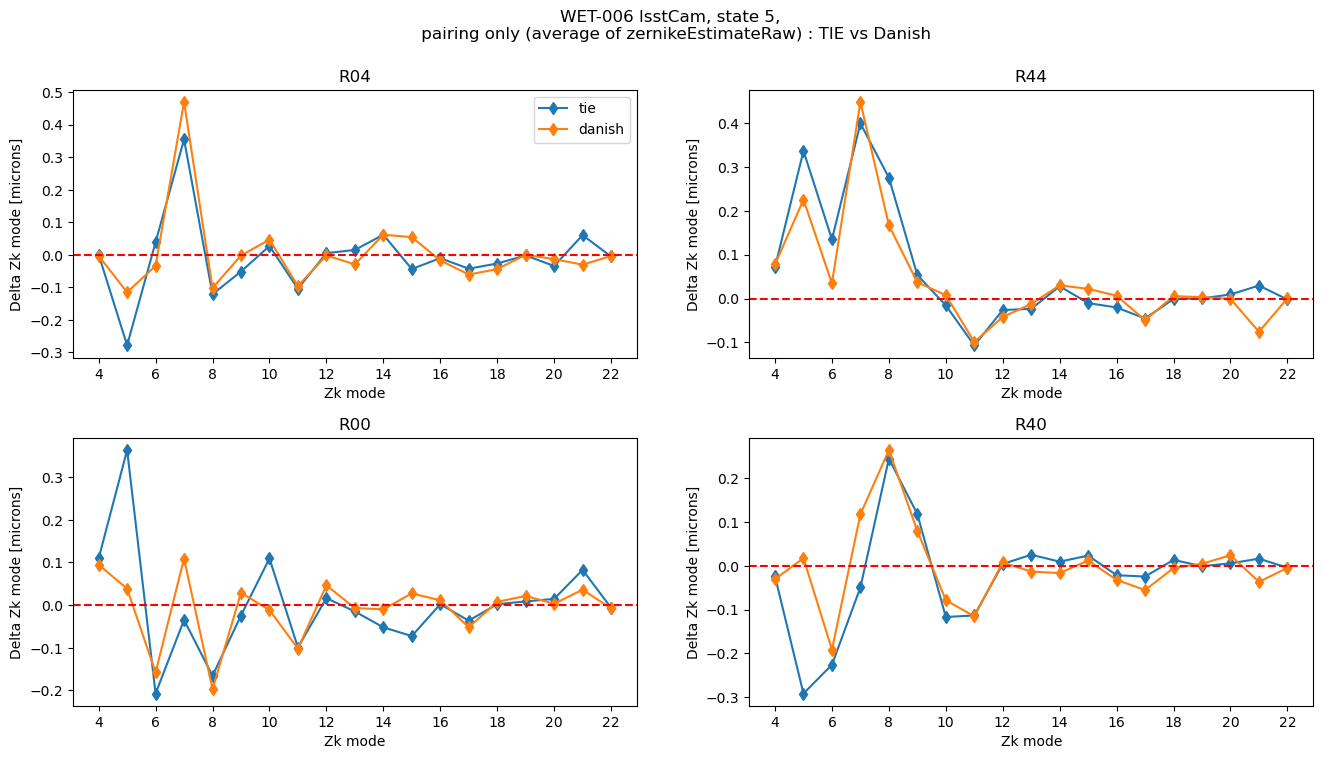

In [11]:
rafts = ['R04', 'R44', 'R00','R40']
state=5

fig,axs = plt.subplots(2,2,figsize=(16,8))
ax = np.ravel(axs)
i=0


# this plots  just the pairing results 
colors = {'danish':'green',  'tie':'orange'}
for raft in rafts:
    
    ax[i].set_title(raft )
    opdId = opd_raft_to_id[raft] 
    opd_zk = 0.001*np.array(all_opd[state][opdId][3:22])
    
    for method in pairing_results.keys():
        # plot pairing  raw zks for danish and tie
        zkRaw = pairing_results[method][state][raft]
        avg_zk = np.mean(zkRaw, axis=0)
     
        rms_diff_avg =  np.sqrt(np.mean(np.square(avg_zk-opd_zk)))
        ax[i].plot(np.arange(4,23), avg_zk-opd_zk, marker='d', label=f'{method}')
      
    ax[i].set_ylabel('Delta Zk mode [microns]')
    ax[i].set_xlabel('Zk mode')
    ax[i].set_xticks([4,6,8,10,12,14,16,18,20,22])
    ax[i].axhline(0,ls='--', c='red')
    
    i+=1
ax[0].legend()#bbox_to_anchor=[1.2,0.8])

fig.subplots_adjust(hspace=0.3)
fig.suptitle(f'WET-006 lsstCam, state {state}, \n pairing only (average of zernikeEstimateRaw) : TIE vs Danish')

Add to that the stacking results for that particular mode:

Text(0.5, 0.98, 'WET-006 lsstCam, state 5, RMS difference (fit - OPD) ')

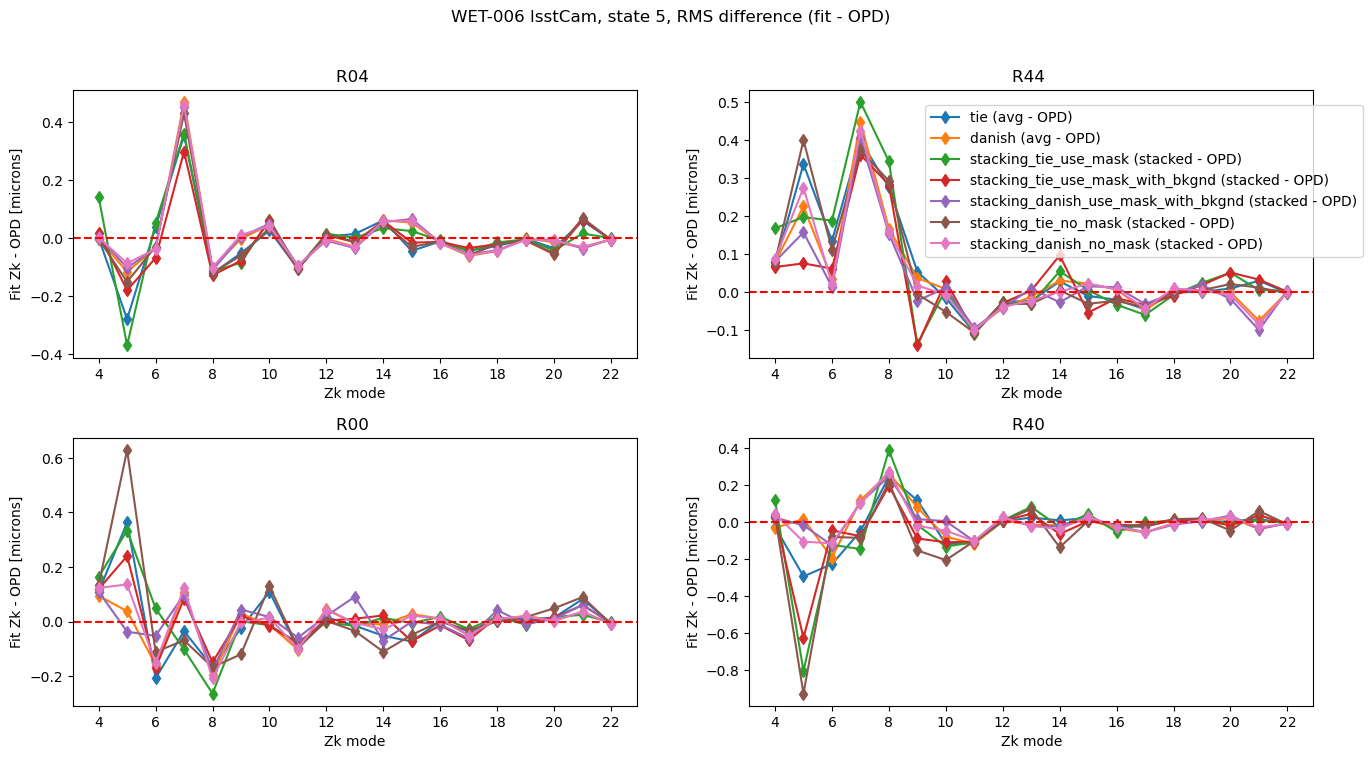

In [35]:
rafts = ['R04', 'R44', 'R00','R40']
state=5

fig,axs = plt.subplots(2,2,figsize=(16,8))
ax = np.ravel(axs)
i=0
# this plots the two sets of  results  
colors = {'danish':'green',  'tie':'orange'}
for raft in rafts:
    
    ax[i].set_title(raft )

    # get OPD for that raft 
    opdId = opd_raft_to_id[raft] # in nm
    opd_zk = 0.001*np.array(all_opd[state][opdId][3:22]) # in microns
    
    for method in pairing_results.keys():
        zkRaw = pairing_results[method][state][raft]
        avg_zk = np.mean(zkRaw, axis=0)
        rms_diff_avg =  np.sqrt(np.mean(np.square(avg_zk-opd_zk)))
       
        ax[i].plot(np.arange(4,23), avg_zk-opd_zk, marker='d',
                   label=f'{method} (avg - OPD)')
     
    for method in stacking_results.keys():
        stacked_zk = stacking_results[method]['results'][state][raft]
        label =  stacking_results[method]['method_string']
        rms_diff_stack = np.sqrt(np.mean(np.square(stacked_zk-opd_zk)))
        ax[i].plot(np.arange(4,23), stacked_zk-opd_zk, marker='d',
                   label=f'{label} (stacked - OPD)')

    ax[i].set_title(f'{raft} ')
    ax[i].set_ylabel('Fit Zk - OPD [microns]')
    ax[i].set_xlabel('Zk mode')
    ax[i].set_xticks([4,6,8,10,12,14,16,18,20,22])
    ax[i].axhline(0,ls='--', c='red')
    
    i+=1
ax[1].legend(bbox_to_anchor=[0.3,0.35])

fig.subplots_adjust(hspace=0.3)
fig.suptitle(f'WET-006 lsstCam, state {state}, RMS difference (fit - OPD) ')

Marginalize this information across all states:

In [36]:
rafts = ['R04', 'R44', 'R00','R40']

rmss={}

# add stacking results 
for j in stacking_results.keys():
    results = stacking_results[j]['results']
    mask_string = stacking_results[j]['mask_string']
    bkgnd_string =  stacking_results[j]['bkgnd_string']
    method =  stacking_results[j]['method']
    method_string = f'stacking_{method}_{mask_string}_mask'
   
    if mask_string == 'use' :
        method_string += f'_{bkgnd_string}_bkgnd'
    rmss[method_string] = {}
    for raft in rafts:
        rmss[method_string][raft] = []
        opdId = opd_raft_to_id[raft] 
        
        for state in range(1,101):
            
            opd_zk = 0.001*np.array(all_opd[state][opdId][3:22])
    
            stacked_zk = results[state][raft]
            rms_diff = np.sqrt(np.mean(np.square(stacked_zk-opd_zk)))


            rmss[method_string][raft].append(rms_diff)

# add pairing results 
for algo in pairing_results.keys():
   method_string = f'pairing_{algo}'
   rmss[method_string] = {}
   for raft in rafts:
       rmss[method_string][raft] = []
       opdId = opd_raft_to_id[raft] 
       
       for state in range(1,101):
            opd_zk = 0.001*np.array(all_opd[state][opdId][3:22])
            avg_zk = np.mean(pairing_results[algo][state][raft], axis=0)
            rms_diff =  np.sqrt(np.mean(np.square(avg_zk-opd_zk)))
            rmss[method_string][raft].append(rms_diff)

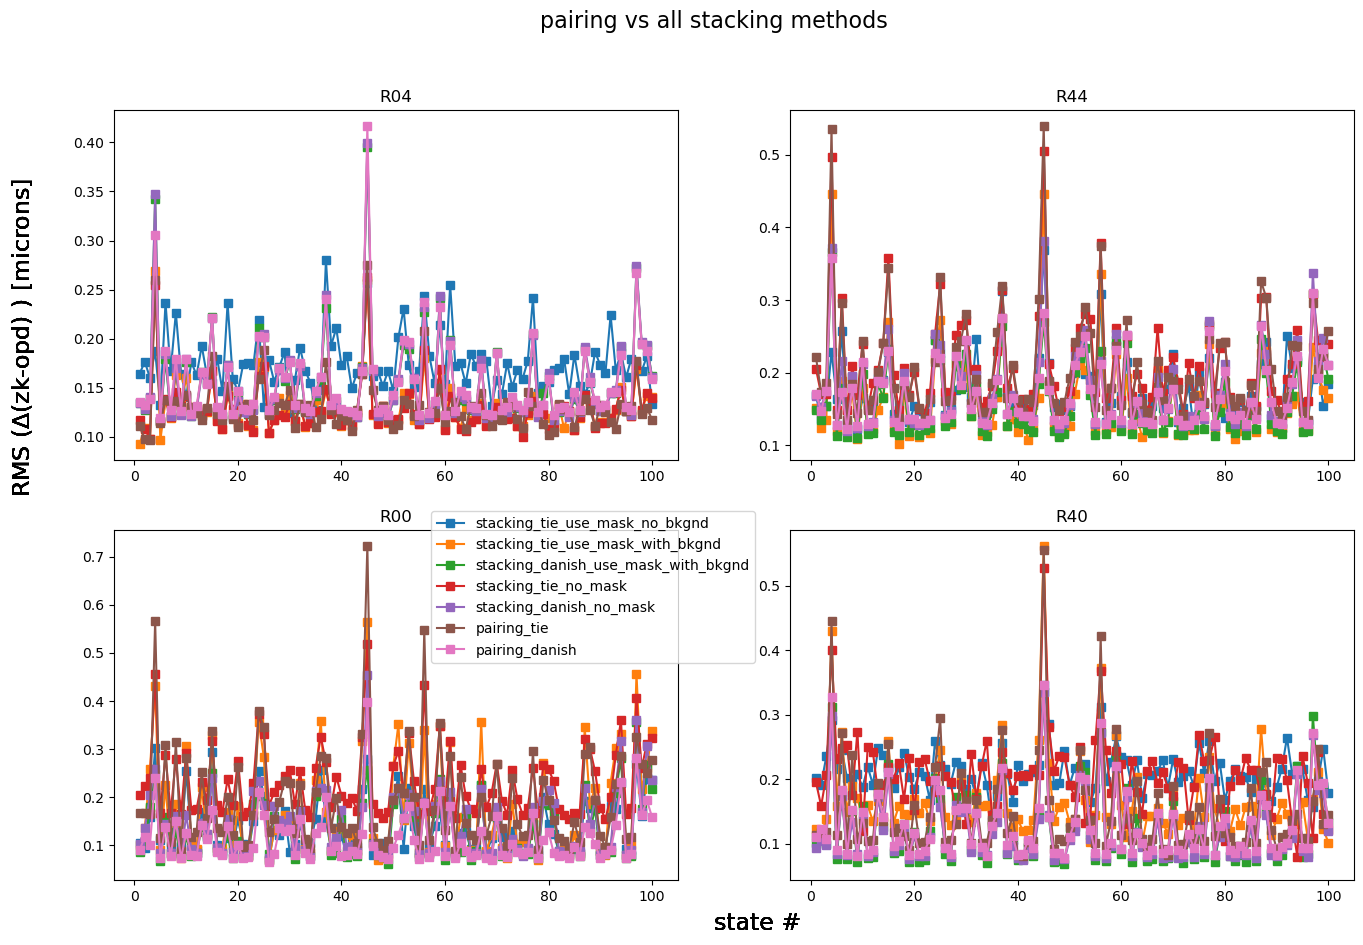

In [63]:
rafts = ['R04', 'R44', 'R00','R40']

fig,axs = plt.subplots(2,2,figsize=(16,10))
ax = np.ravel(axs)

for method in rmss.keys():
    i=0
    for raft in rafts:
        ax[i].plot(np.arange(1,101), rmss[method][raft], marker='s', label=f'{method}')
        ax[i].set_title(raft)
        i+=1
    
    fig.text(0.5,0.06,'state #', fontsize=17)
    fig.text(0.06,0.5,r'RMS ($\Delta$(zk-opd) ) [microns] ', rotation=90, fontsize=17)
fig.suptitle('pairing vs all stacking methods', fontsize=16)
ax[2].legend(bbox_to_anchor=[0.55,.6])

There is no clear preference for any particular method: while for R04 "stacking, TIE, with mask, no background" (blue) has the largest departure from the OPD, for R00 this is not the case. "Pairing Danish" (pink) has the smallest deviation from the OPD for R00, and is only marginally worse than the "stacking Danish with mask and background" (green) option for R44 and R40. To make it easier to see the deviation from the OPD, below we calculate the mean RMS difference across all states per detector per method:

In [46]:
from matplotlib import colormaps as cmaps
from astropy.table import Table

means_arr = []
rafts_arr = []
methods_arr = []
rafts = ['R04', 'R44', 'R00','R40']
for raft in rafts:
    for method in rmss.keys():
        mean_rms = np.median( rmss[method][raft]) 
        means_arr.append(mean_rms)
        rafts_arr.append(raft)
        methods_arr.append(method)
mean_rms_table = Table(data=[means_arr, rafts_arr, methods_arr], names=['mean_rms', 'raft', 'method'])

In [47]:
for raft in rafts:
    per_raft = mean_rms_table[mean_rms_table['raft'] == raft]# .sort('mean_rms')
    per_raft.sort('mean_rms')
    print(per_raft)

      mean_rms      raft                method              
------------------- ---- -----------------------------------
0.12245982433194912  R04    stacking_tie_use_mask_with_bkgnd
0.12287115478025104  R04                stacking_tie_no_mask
 0.1272135180411988  R04                         pairing_tie
 0.1337388102052313  R04             stacking_danish_no_mask
 0.1342364041823671  R04 stacking_danish_use_mask_with_bkgnd
0.13711868256738124  R04                      pairing_danish
0.16788752144434005  R04      stacking_tie_use_mask_no_bkgnd
      mean_rms      raft                method              
------------------- ---- -----------------------------------
0.13367654248935212  R44 stacking_danish_use_mask_with_bkgnd
0.13394723071818743  R44    stacking_tie_use_mask_with_bkgnd
0.15050260405928126  R44                      pairing_danish
 0.1521178698309197  R44             stacking_danish_no_mask
 0.1597151828776096  R44      stacking_tie_use_mask_no_bkgnd
 0.1836104280153719  R44

We can also marginalize across detectors, summarizing the RMS difference between each method taking the average per four sensors:

In [48]:
mean_per_state = {}
for method in rmss.keys():
    all_raft_data = []
    for raft in rafts:
        all_raft_data.append( rmss[method][raft])
    mean_per_state[method] = np.mean(all_raft_data,axis=0)

Plot per state: 

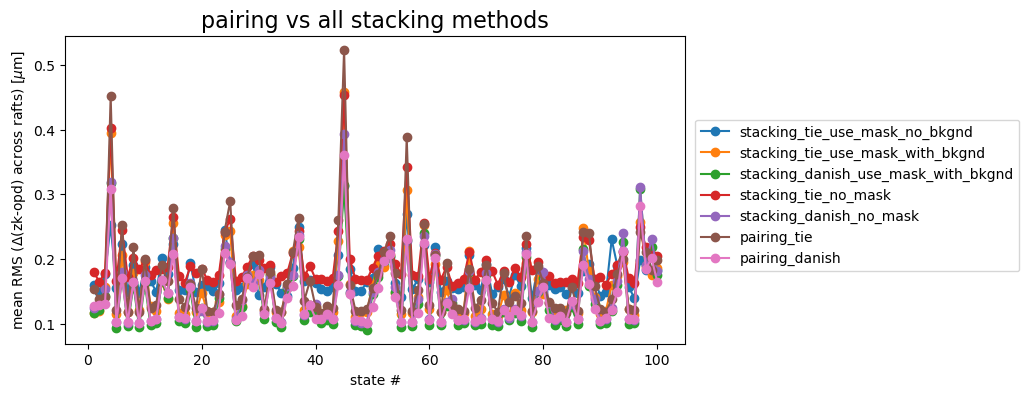

In [49]:
import matplotlib.pyplot as plt 
from matplotlib import colormaps as cmaps
rafts = ['R04', 'R44', 'R00','R40']
cmap = cmaps['tab10']

fig,ax = plt.subplots(1,1,figsize=(8,4))
j=0
for method in mean_per_state.keys():
    
    ax.plot(np.arange(1,101), mean_per_state[method], marker='o', label=f'{method}',
           c=cmap(j))
    j+=1
      
ax.set_xlabel('state #')
ax.set_ylabel(r'mean RMS ($\Delta$(zk-opd) across rafts) '+r'[$\mu$m]',)
ax.set_title('pairing vs all stacking methods', fontsize=16)
ax.legend(bbox_to_anchor=[1.55,0.75])

If we consider pairing with Danish as the default, the plot below shows the difference between Danish and other methods. The horizontal dashed line at $\Delta=0$ is added for reference.

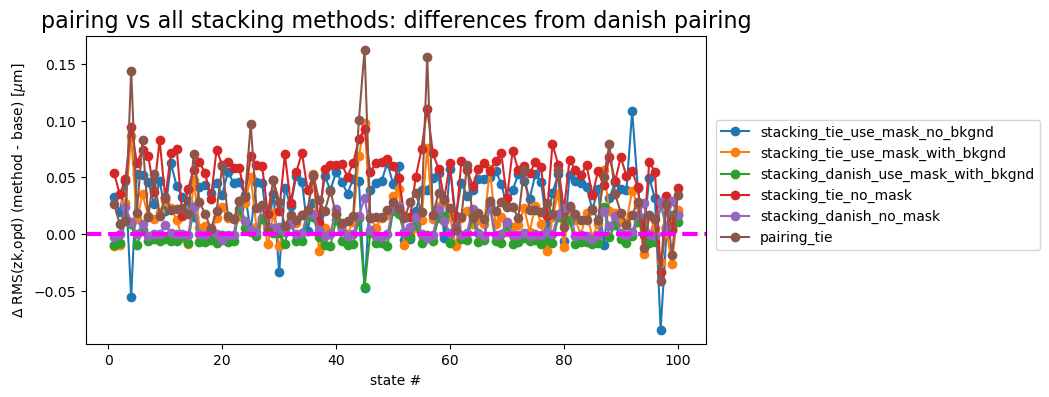

In [59]:
import matplotlib.pyplot as plt 
from matplotlib import colormaps as cmaps
rafts = ['R04', 'R44', 'R00','R40']
cmap = cmaps['tab10']

fig,ax = plt.subplots(1,1,figsize=(8,4))
j=0
base = mean_per_state['pairing_danish']
for method in mean_per_state.keys():
    if method != 'pairing_danish':
        diff = mean_per_state[method] - base 
        ax.plot(np.arange(1,101), diff, marker='o', label=f'{method}', c=cmap(j))
    j+=1
ax.axhline(0,ls='--', lw=3, c='magenta')
ax.set_xlabel('state #')
ax.set_ylabel(r'$\Delta$ RMS(zk,opd) (method - base) '+r'[$\mu$m]',)
ax.set_title('pairing vs all stacking methods: differences from danish pairing', fontsize=16)
ax.legend(bbox_to_anchor=[1.55,0.75])

Show just the two pairing methods:

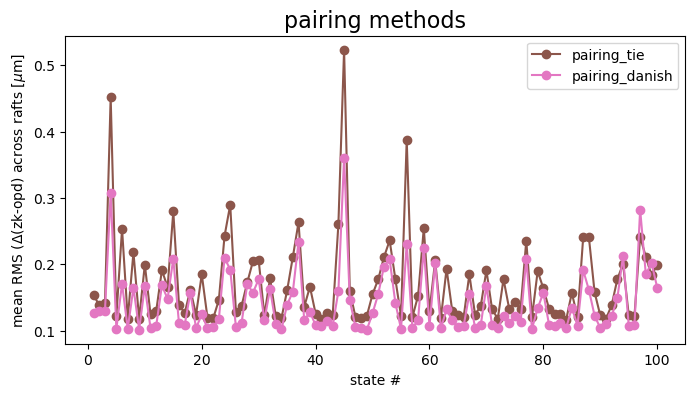

In [51]:
import matplotlib.pyplot as plt 
rafts = ['R04', 'R44', 'R00','R40']

fig,ax = plt.subplots(1,1,figsize=(8,4))
cmap = cmaps['tab10']
j=0
for method in mean_per_state.keys():
    if method.startswith('pairing'):
        ax.plot(np.arange(1,101), mean_per_state[method], marker='o', label=f'{method}', c=cmap(j))
    j +=1 
ax.set_xlabel('state #')
ax.set_ylabel(r'mean RMS ($\Delta$(zk-opd) across rafts '+r'[$\mu$m]',)
ax.set_title('pairing methods', fontsize=16)
ax.legend()

Danish appears to overall produce results closer to the OPD.

Most stacking results are not as good as pairing for  Danish:

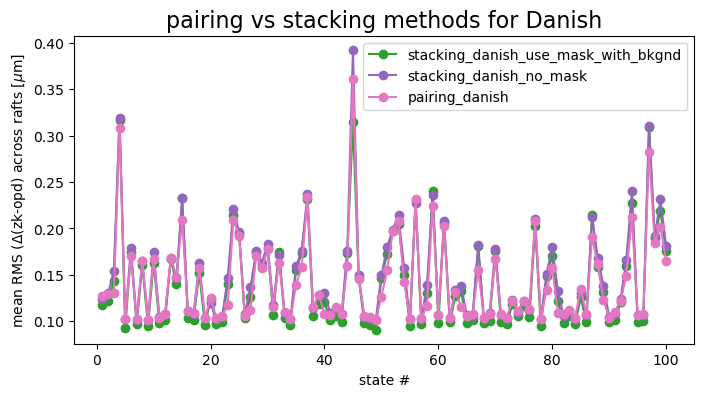

In [52]:
import matplotlib.pyplot as plt 
rafts = ['R04', 'R44', 'R00','R40']

fig,ax = plt.subplots(1,1,figsize=(8,4))
cmap = cmaps['tab10']
j=0
for method in mean_per_state.keys():
    if 'danish' in method:
        ax.plot(np.arange(1,101), mean_per_state[method], marker='o', label=f'{method}', c=cmap(j))
    j +=1 
ax.set_xlabel('state #')
ax.set_ylabel(r'mean RMS ($\Delta$(zk-opd) across rafts '+r'[$\mu$m]',)
ax.set_title('pairing vs stacking methods for Danish', fontsize=16)
ax.legend()

This can be also shown as absolute differences:

pairing_danish -  stacking_danish_use_mask_with_bkgnd  mean difference:  0.0001616620313260622
pairing_danish -  stacking_danish_no_mask  mean difference:  0.0066782778509112024


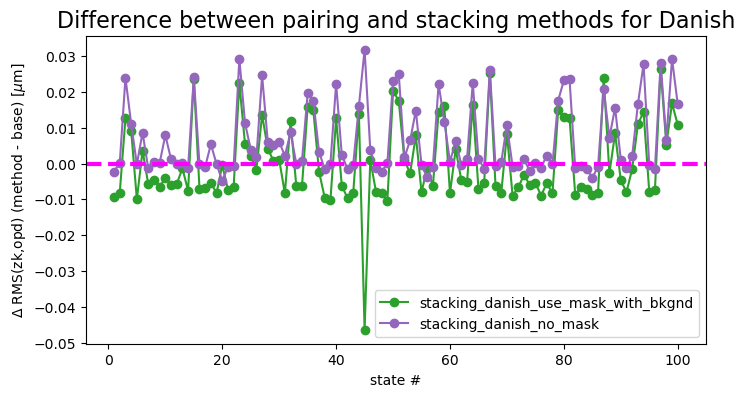

In [60]:
import matplotlib.pyplot as plt 
rafts = ['R04', 'R44', 'R00','R40']

fig,ax = plt.subplots(1,1,figsize=(8,4))
cmap = cmaps['tab10']
j=0
base = mean_per_state['pairing_danish']
for method in mean_per_state.keys():
    if 'danish' in method:
         if method != 'pairing_danish':
           diff = mean_per_state[method] - base 
           ax.plot(np.arange(1,101), diff, marker='o', label=f'{method}', c=cmap(j))
           print('pairing_danish - ', method, ' mean difference: ', np.mean(diff), )
    j +=1 
ax.set_xlabel('state #')
ax.set_ylabel(r'$\Delta$ RMS(zk,opd) (method - base) '+r'[$\mu$m]',)
ax.axhline(0,ls='--', lw=3, c='magenta')
ax.set_title('Difference between pairing and stacking methods for Danish', fontsize=16)
ax.legend()

Thus for Danish, while with some states we may see decreased RMS when using stacking with mask and added mean background, for other states the same method performs more poorly than pairing. Averaging across all states, both stacking strategies are slightly worse than the pairing (at 0.1 nm - 6 nm mean level).

For TIE, stacking also does not provide statistically significant improvement over pairing, the RMS floor being around 0.09 $\mu m$ for both approaches:

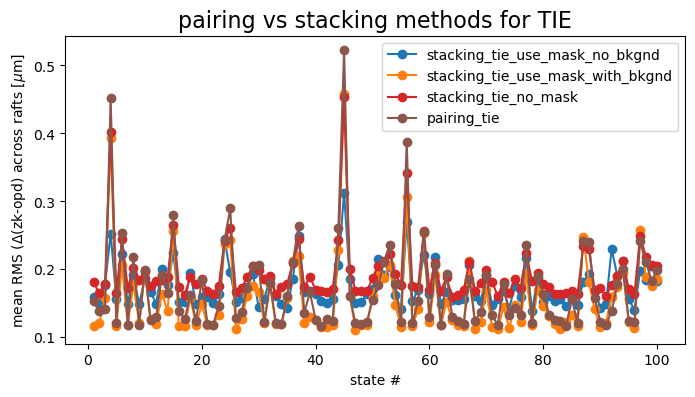

In [54]:
import matplotlib.pyplot as plt 
rafts = ['R04', 'R44', 'R00','R40']

fig,ax = plt.subplots(1,1,figsize=(8,4))
cmap = cmaps['tab10']
j=0
for method in mean_per_state.keys():
    if 'tie' in method:
        ax.plot(np.arange(1,101), mean_per_state[method], marker='o', label=f'{method}', c=cmap(j))
    j +=1 
ax.set_xlabel('state #')
ax.set_ylabel(r'mean RMS ($\Delta$(zk-opd) across rafts '+r'[$\mu$m]',)
ax.set_title('pairing vs stacking methods for TIE', fontsize=16)
ax.legend()

We similarly can show the difference between pairing and stacking:

pairing_tie - stacking_tie_use_mask_no_bkgnd  mean difference:  0.004362085537256819
pairing_tie - stacking_tie_use_mask_with_bkgnd  mean difference:  -0.013307982598863802
pairing_tie - stacking_tie_no_mask  mean difference:  0.023729023100608534


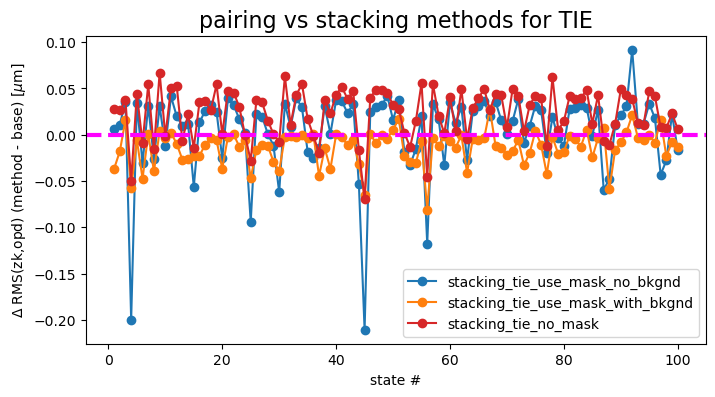

In [61]:
import matplotlib.pyplot as plt 
rafts = ['R04', 'R44', 'R00','R40']

fig,ax = plt.subplots(1,1,figsize=(8,4))
cmap = cmaps['tab10']
j=0
base = mean_per_state['pairing_tie']
for method in mean_per_state.keys():
    if 'tie' in method:
         if method != 'pairing_tie':
           diff = mean_per_state[method] - base 
           ax.plot(np.arange(1,101), diff, marker='o', label=f'{method}', c=cmap(j))
           print('pairing_tie -', method, ' mean difference: ', np.mean(diff), )
    j +=1 
ax.axhline(0,ls='--', lw=3, c='magenta')
ax.set_xlabel('state #')
ax.set_ylabel(r'$\Delta$ RMS(zk,opd) (method - base) '+r'[$\mu$m]',)
ax.set_title('pairing vs stacking methods for TIE', fontsize=16)
ax.legend()

These differences oscillate around 0, with "stacking with TIE without mask" (red) as well as  "stacking with mask with background" being on average  above 0 (i.e. larger RMS departure from OPD than the baseline pairing approach). Stacking with mask and background performs marginally better than pairing for some states. (mean 0.01 $\mu m$ below pairing). 

In summary, based on the WET-001 simulation we do not see that there is a clear advantage in introducing stacking over using the existing approach of pairing.